###### Author: Florian Heringa 
###### Title: Motion Tracking Lab: exercise set
###### Course: Image processing and computer vision
###### UvA

In [1]:
# Import statements

import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile
import imageio
from pprint import pprint
import cv2
from scipy.signal import convolve, fftconvolve

import matplotlib.animation as animation
from skimage.feature import match_template

from pylab import rcParams

#ipython setting
#%matplotlib notebook
rcParams['figure.figsize'] = (10, 6)

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Tracking

In this report we consider motion tracking. This will be done by first implementing a simple tracking of a ball based on the match_template fucntion from the skimage.feature package. A viseo of a ball being thrown is used for the tracking. The ball will follow a parabolic trajectory under the influence of gravity, which will be visualised using the tracking algorithm. For this we choose a template in one of the first frames (frame 40 in this case, since the ball is fully visible there) and check in every successive frame where this template can be found. When the template is found the location within the image is saved and finally plotted as a scatter plot showing the trajectory of the ball.

Unfortunately the algorithm is extremely slow, owing to the inherent slowness of the function combined wth the filesize of the image. Because of this I would suggest not running the code below and just taking a look at the video and image contained in the archive.

{'duration': 14.4,
 'ffmpeg_version': '2.8.11-0ubuntu0.16.04.1 built with gcc 5.4.0 (Ubuntu '
                   '5.4.0-6ubuntu1~16.04.4) 20160609',
 'fps': 29.97,
 'nframes': 432,
 'plugin': 'ffmpeg',
 'size': (640, 360),
 'source_size': (640, 360)}


<IPython.core.display.Javascript object>


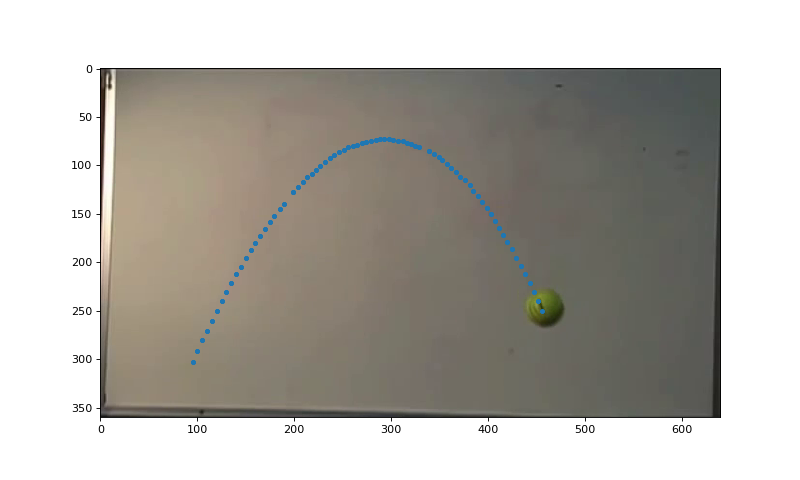

In [15]:
# Create a reader for the mp4 video
videofile = 'ball2.mp4'
reader = imageio.get_reader(videofile)

pprint(reader.get_meta_data())
# Get first frame for getting template
first_frame = reader.get_data(40)

fig, ax = plt.subplots()
template = first_frame[275:325, 70:125]
# match_template returns the upper left location of where the template is found, offset is used
# to calculate the location of the center of the ball to plot a marker there each frame.
offset = [x / 2 for x in template.shape]
loc_x = []
loc_y = []

# Find the position of the ball for frames 30-350
for i in range(40, 350):
    
    # Returns a list of correlation coefficients per position in image
    result = match_template(reader.get_data(i), template)
    # Find the index of the largest correlation coefficient
    ij = np.unravel_index(np.argmax(result), result.shape)
    # Correction for axis definition
    x, y = ij[1], ij[0]
    # Save location for use in scatter plot
    loc_x.append(x + offset[0])
    loc_y.append(y + offset[1])

ax.scatter(loc_x, loc_y, s=10)
ax.imshow(reader.get_data(350))
ax.axis("off")
plt.show()

#####
## The following section is used for saving an animation of the ball, the saved animation is supplied in the
## archive. Rendering this animation takes aout 15 minutes so the code has been commented.
    
def animate(i):
    
    # Get new frame
    this_frame = reader.get_data(i + 40)
    # Set axis to plot frame
    img.set_data(this_frame)
    # Find the template, same as above
    result = match_template(this_frame, template)
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[1], ij[0]
    # Update position of marker
    scat.set_offsets((x + offset[0], y + offset[1]))
    return img, scat

# fig_anim, ax_anim = plt.subplots()
# img = plt.imshow(first_frame)
# scat = plt.scatter(100, 300)
# ani = animation.FuncAnimation(fig_anim, animate, reader.get_length() - 50, interval=25)

# ani.save("trackBall3.mp4", writer="ffmpeg")
# plt.show()

## Implementing a tracker

To implement a tracker function we need to make use of the normalised cross correlation. This measure is used to see how much two samples are the same. Intuitively we can consider this in this case by taking the template and shifting it over the image at each pixel position and seeing how much it is correlated with that position. In code we can use clever tricks to simplify this method so we don't have to shift over the entire image, which would take enormous amounts of time. This is done in the match_template function (which still is quite slow for larger images). I will however be attempting the slower version which is done by explicitly calculating convolutions of the image and the template at each frame. This is because the design of the match_template function is not fully understood by me and I would not feel comfortable blatantly copying the contents.

The normalised cross correlation is here defined to be

\begin{split}
\text{ncc} = \frac{f \ast \hat m^\star}{
\sqrt{f^2\ast[\mathcal{M}]^\star - \frac{1}{M}(f\ast[\mathcal{M}]^\star)^2 }}
\end{split}

where f is the image to be considered, m is the chosen mask and $[\mathcal{M}]$ is the indicator function of the mask. The formula above means that we take the correlation between the image and the mask in the numerator and divide by a normalisation factor depending on the position in the image where we are looking. This formula is actually a function of the position in the image and will thus yield a new image where the values of the pixels are the value of the normalised cross-correlation at each point.

After this we can simply find where this image has a maximum and this is where the mask was found within the image.

In [4]:
videofile = 'ball2.mp4'
reader = imageio.get_reader(videofile)
first_frame = reader.get_data(40)
reader.close()

# Convert image to grayscale
gray_image = cv2.cvtColor(first_frame[::, ::, ::-1], cv2.COLOR_BGR2GRAY)
# Select template from first frame
template = gray_image[275:325, 70:125]
offset = [x / 2 for x in template.shape]

# Normalise the template by subtracting mean and dividing by standard deviation
def normaliseTemplate(template):
    reshaped = np.reshape(template, template.size)
    return (template - sum(reshaped) / reshaped.size) / np.std(reshaped)

# Normalised template
normalised_template = normaliseTemplate(template)
# Indicator function
indicator = np.ones(template.shape)

## Here we make use of the 'valid' keyword, which only takes the parts of the image which are not
## subject to border effects

# Convolution to get numerator with reversed template (actually correlation)
num = convolve(gray_image, normalised_template[::-1, ::-1], mode='valid')

# Convolution for both denominator parts
den1 = convolve(np.multiply(gray_image, gray_image), indicator, mode='valid')
den2 = convolve(gray_image, indicator, mode='valid')
den2 = np.multiply(den2, den2) / template.size

den_tot = den1 - den2

# Change every value that is negative to zero before taking the square root
den_tot = np.maximum(den_tot, 0)
den_tot = np.sqrt(den_tot)

# Mask all values in the denominator that are less than machine epsilon (lowest possible float64 value)
mask = den_tot > np.finfo(np.float64).eps
ncc = np.zeros_like(num, dtype=np.float64)
ncc[mask] = num[mask] / den_tot[mask]

ij = np.unravel_index(np.argmax(ncc), ncc.shape)

# Unforunately this is where it ends, the function refusees to give a meaningful coordinate.

I was not able to implement the function myself, den2 in the above code section ive very high values causing den_tot to be negative at all points. This in turn makes the code set every value to 0, after which nothing is left to compute since the mask now filters out all values. I really have not been able to find what is going on after hours of trying to debug this mess. Changing the mode of the convolution will actually give an answer but unfortunately this lies outside the image and thus has no meaning.

## Mouse tracking

In this section we look at the footage recorded by a laser mouse moving over a surface (lika a table). To move the mouse on the screen when it is physically moved we need to determine a way to interpret this footage and translate it to a x- and y-position change. This can be done by choosing a template in the middle of the screen and checking each successive frame how much and in which direction this section moved. Then the template is again defined to be the center of the screen and the process is repeated.

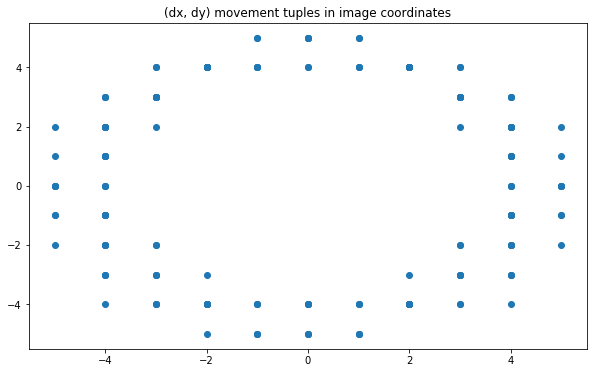

In [70]:
filename = 'mousemovie.mp4'

reader = imageio.get_reader(filename)

meta_data = reader.get_meta_data()
first_frame = reader.get_data(0)

template_size = 8
img_size_x, img_size_y = meta_data.get('size')
template = first_frame[int((img_size_y - template_size) / 2):int((img_size_y + template_size) / 2),
                       int((img_size_x - template_size) / 2):int((img_size_x + template_size) / 2)]


loc_x = []
loc_y = []
middle = ((img_size_x - template_size) / 2, (img_size_y - template_size) / 2)
movement = []

for i in range(1, reader.get_length()):
    
    # Get new frame from reader
    new_frame = reader.get_data(i)
    # Match template within new frame
    result = match_template(new_frame, template)
    # Get location of the match
    ij = np.unravel_index(np.argmax(result), result.shape)[:2]
    x, y = ij[1], ij[0]
    # store (dx, dy)
    movement.append((middle[0] - x, middle[1] - y))
    # Define new template in center of new frame
    template = new_frame[int((img_size_y - template_size) / 2):int((img_size_y + template_size) / 2),
                         int((img_size_x - template_size) / 2):int((img_size_x + template_size) / 2)]

plt.scatter(*zip(*movement))
plt.title("(dx, dy) movement tuples in image coordinates")
plt.show()

In [100]:
# Takes in an list of (dx, dy) tuples in image coordinates. The function takes care of the conversion
# during execution. This means that dy = -dy.
# The blue ircle is the computed path. The red circle is a unit circle scaled up to approximately the 
# size of the movement (in this case by 130).
def plotPath(delta_s):
    
    # Guess from results where start position approximately is to get circle centered on (0, 0)
    xs = [130]
    ys = [0]
    
    fig, ax = plt.subplots()
    
    for i in range(len(delta_s)):
        
        xs.append(xs[-1] + delta_s[i][0])
        ys.append(ys[-1] - delta_s[i][1])
        
        if i % 10 == 0:
            x_loc = xs[-1] if xs[-1] > 0 else xs[-1] - 30
            y_loc = ys[-1] if ys[-1] > 0 else ys[-1] - 20
            ax.text(x_loc, y_loc, 'i = %d' % (i))
        
    t = np.arange(0, 2 * np.pi, .1)
    ax.plot(xs, ys, 'b-')
    ax.set_xlim(-175, 175)
    ax.set_ylim(-175, 175)
    ax.plot(130*np.cos(t), 130*np.sin(t), 'r-')
    ax.set_aspect("equal")
    plt.show()
    
plotPath(movement)